# Feb 11, 2026: reduce size of individual estimates
sample 1000 partitions in total from the modes made from 15,000 partitions

conda env: gt

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill as pickle 
from scipy import sparse, stats
from scipy.special import gammaln
import graph_tool.all as gt
from glob import glob
import re 
from tqdm import tqdm
from itertools import combinations
import math
from joblib import Parallel, delayed
import random 
from sklearn.preprocessing import OneHotEncoder

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow


# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

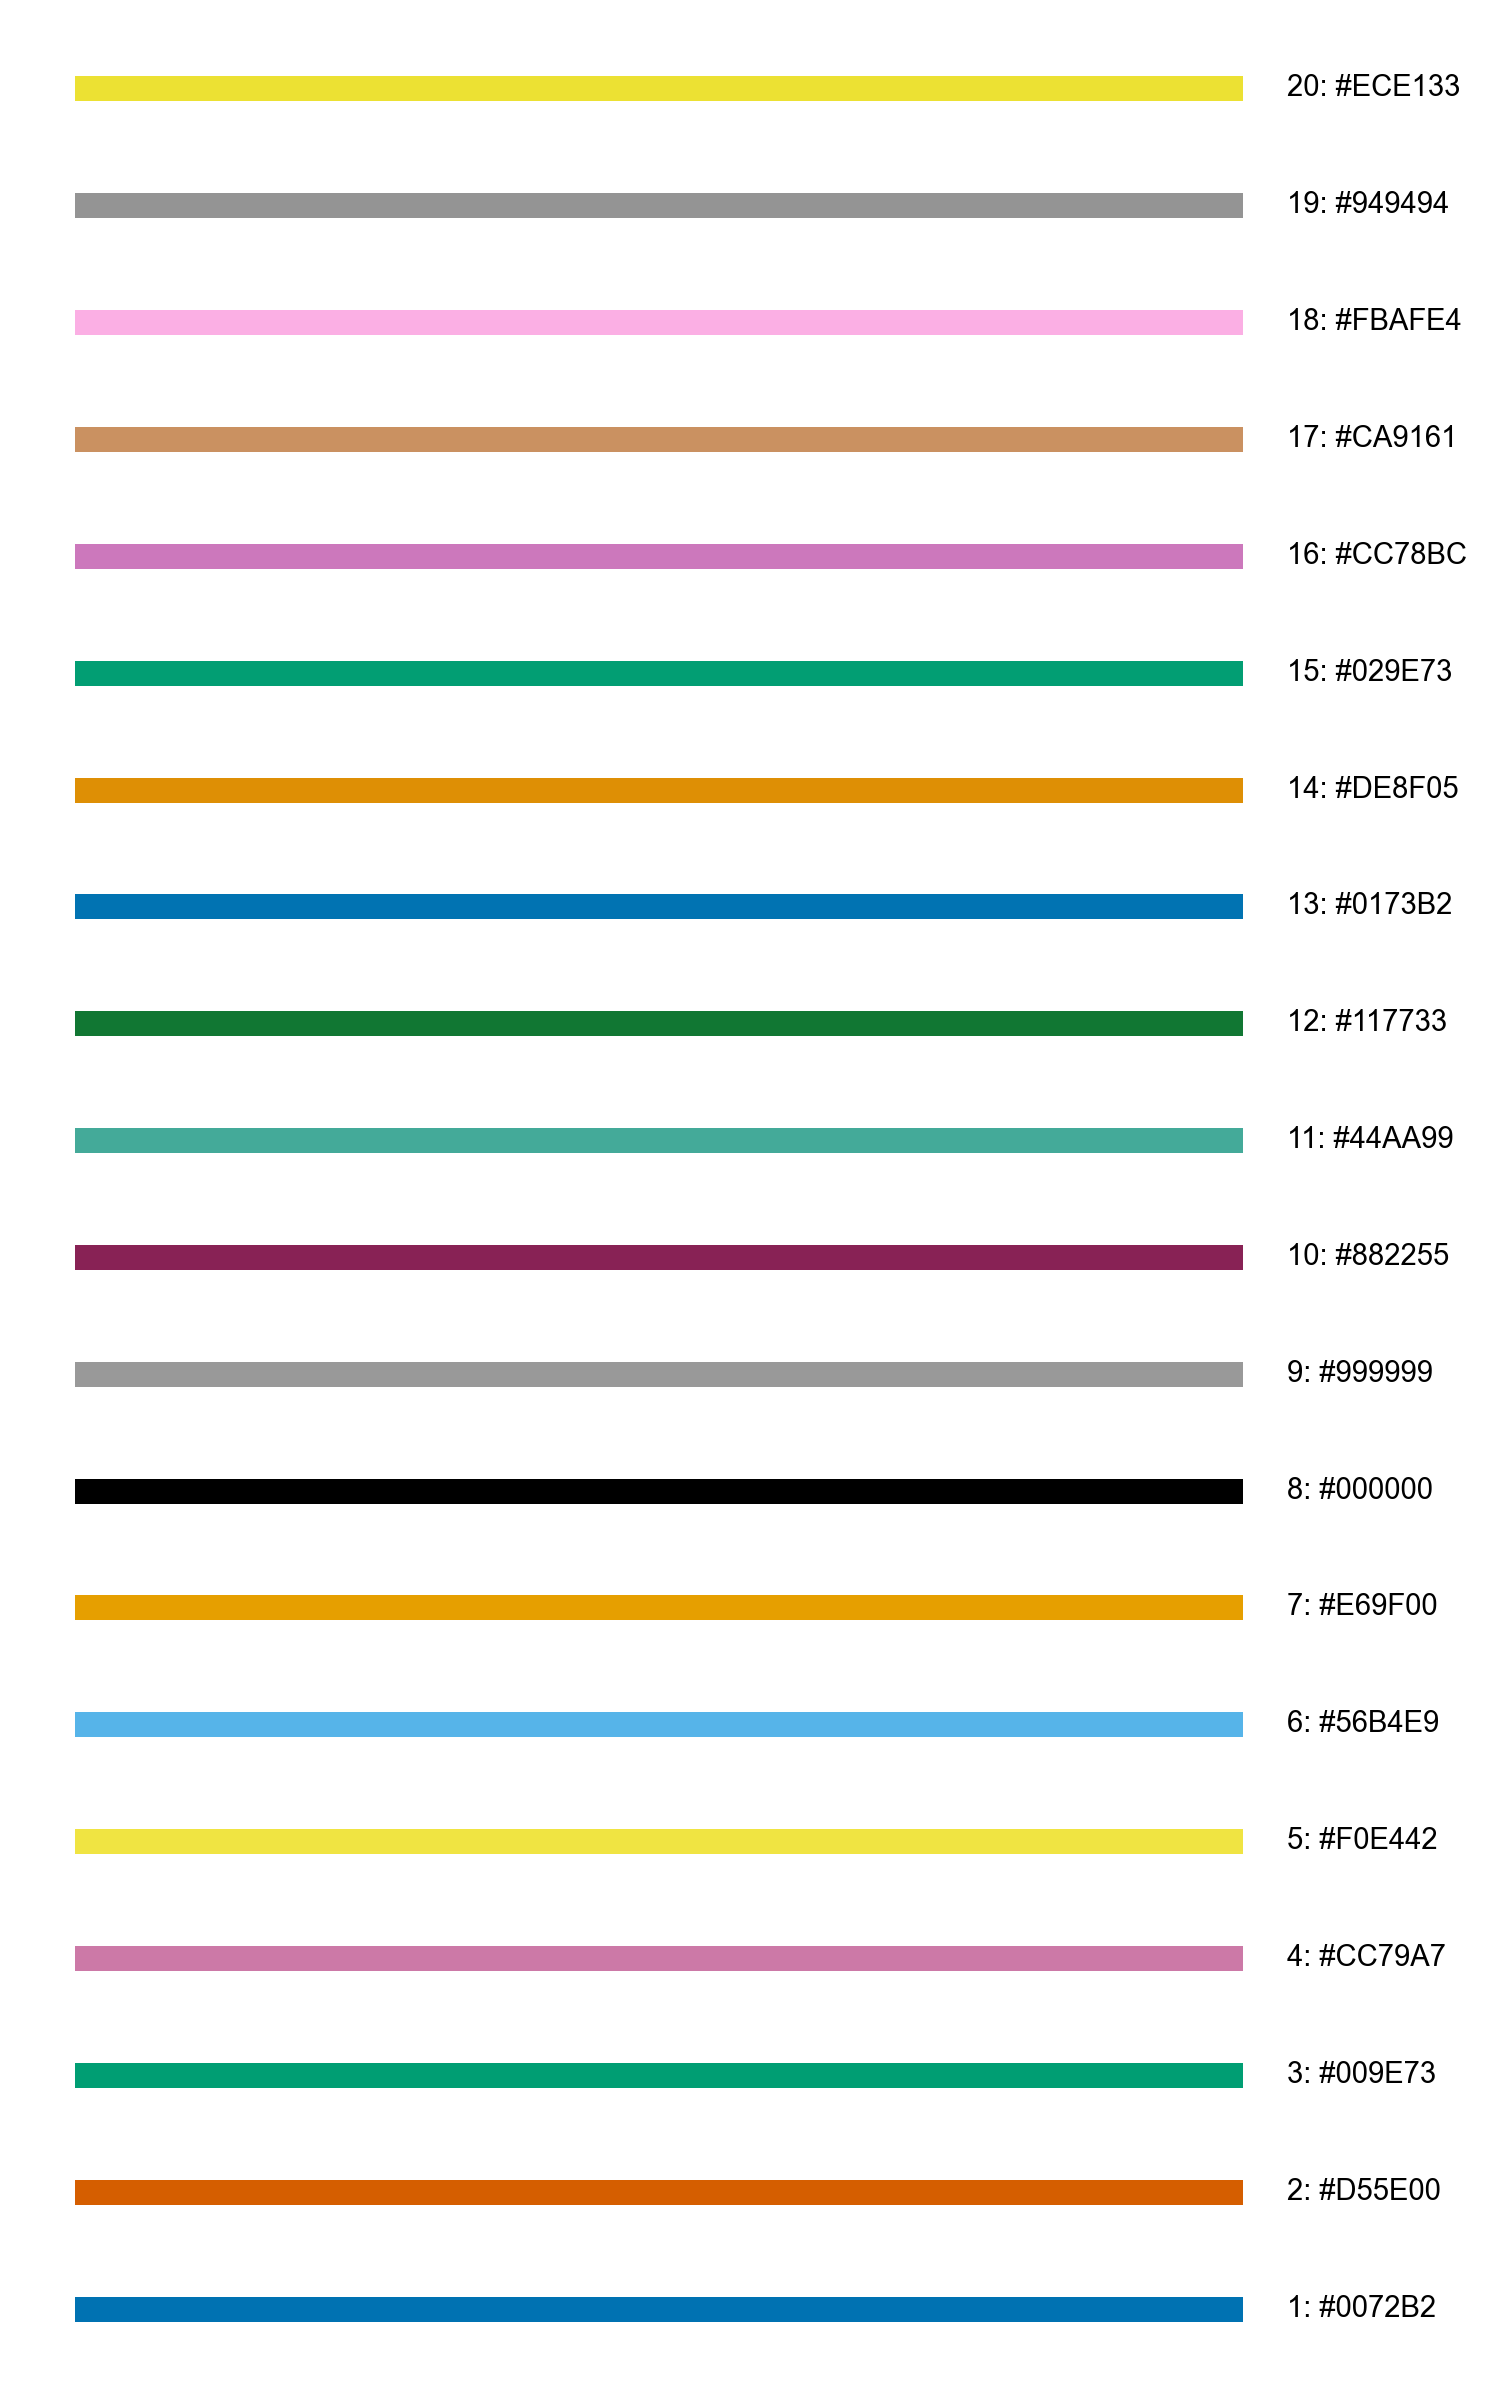

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.ANALYSIS = 'trial-end'
# args.WINDOW = np.arange(5, 8+1)
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'sub'

BASE_path = f'/home/govindas/lab-data/aba'
PARC_DESC = f'NEWMAX_ROIs_final_gm_100_2mm' #f'NEWMAX_ROIs_final_gm_104_2mm' #f'ABA_ROIs_final_gm_36'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)
TS_path = f'{ROI_path}/roi-timeseries'
os.makedirs(TS_path, exist_ok=True)

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/cond-*/graphs'
SBM_path = f'{ROI_RESULTS_path}/cond-*/model-fits'
ESTIM_path = f'{ROI_RESULTS_path}/cond-*/estimates/individual'

In [7]:
args.dc, args.sbm = False, 'h'
args.nested = args.sbm == 'h'

args.force_niter = 100000
args.num_draws = int((1/2) * args.force_niter)

args.epsilon = 0.4 # threshold KSD for convergence
args.delta = np.ceil(args.force_niter / 100).astype(int)

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm-nd-h'

In [8]:
def sample_partitions(sub, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        df = pd.DataFrame(dict(
            sub=[sub]*len(bs),
            cond=[row['cond']]*len(bs),
            mode_id=[idx]*len(bs),
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(sub, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        # bs = [gt.nested_partition_clear_null(b) for b in bs]
        df = pd.DataFrame(dict(
            sub=[sub]*len(bs),
            cond=[row['cond']]*len(bs),
            mode_id=[idx]*len(bs),
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [9]:
def create_reduced_indiv_estim(args, indiv_file):
    try:
        # load individual estimates
        with open(indiv_file, 'rb') as f:
            df = pickle.load(f)
        
        # make output folder
        match = re.search(r'cond-([^/]+).*sub-([^/]+)', indiv_file)
        if match:
            cond = match.group(1)
            sub = match.group(2)
        red_indiv_path = (
            f'{ROI_RESULTS_path}/cond-{cond}/estimates/individual'
            f'/sub-{sub}/partition-modes-reduced'
        )
        os.makedirs(red_indiv_path, exist_ok=True)
        
        # sample partitions from mode
        args.total_samples = 1000
        df['num_samples'] = df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int) if x > 0.01 else 1)
        if args.sbm in ['m', 'a', 'd']:
            all_bs_df = sample_partitions(sub, df)
        if args.sbm in ['h']:
            all_bs_df = sample_nested_partitions(sub, df)
            
        # create the indiv_estim_df
        red_df = []
        for mode_id, group in all_bs_df.groupby('mode_id'):
            mode = gt.PartitionModeState(group['b'], relabel=False, nested=args.nested, converge=False)
            r = df[df['mode_id'] == mode_id].reset_index(drop=True)
            row = pd.DataFrame(dict(
                sub=[sub],
                cond=[cond],
                sbm=[r['sbm'][0]],
                mode_id=[mode_id],
                mode=[mode],
                omega=[r['omega'][0]],
                sigma=[r['sigma'][0]],
            ))
            red_df += [row]
        red_df = pd.concat(red_df).reset_index(drop=True)
        
        # save the df
        with open(f'{red_indiv_path}/{SBM}_desc-df.pkl', 'wb') as f:
            pickle.dump(red_df, f)
        
    except:
        pass
    
    return None

In [10]:
indiv_files = sorted(glob(f'{ESTIM_path}/sub-*/partition-modes/{SBM}_desc-df.pkl'))
indiv_files

['/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_100_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/cond-highR/estimates/individual/sub-ABA602/partition-modes/sbm-nd-h_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_100_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/cond-highR/estimates/individual/sub-ABA603/partition-modes/sbm-nd-h_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_100_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/cond-highR/estimates/individual/sub-ABA604/partition-modes/sbm-nd-h_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_100_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-sub/cond-highR/estimates/individual/sub-ABA606/par

In [11]:
results = Parallel(n_jobs=10)(
    delayed(create_reduced_indiv_estim)(args, indiv_file)
    for indiv_file in indiv_files
)

12it [00:00, 46.46it/s]
34it [00:00, 148.61it/s]
28it [00:00, 102.51it/s]
8it [00:00, 28.02it/s]
17it [00:00, 36.66it/s]
14it [00:00, 53.68it/s]
28it [00:00, 117.02it/s]
22it [00:00, 91.45it/s]
17it [00:00, 65.46it/s]
17it [00:00, 62.42it/s]
9it [00:00, 38.86it/s]
18it [00:00, 102.66it/s]
27it [00:00, 131.82it/s]
23it [00:00, 98.98it/s]
25it [00:00, 111.27it/s]
25it [00:00, 120.10it/s]
27it [00:00, 121.87it/s]
24it [00:00, 105.39it/s]
14it [00:00, 60.41it/s]
22it [00:00, 99.49it/s]
